<a href="https://colab.research.google.com/github/Poojitha-Kokkalla/EnhancedNST/blob/main/MajorProjectFinalImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ---------- VGG Feature Extractor ----------
class VGGFeatures(nn.Module):
    def __init__(self, content_layers, style_layers):
        super(VGGFeatures, self).__init__()
        self.model = models.vgg19(pretrained=True).features.eval()
        self.content_layers = content_layers
        self.style_layers = style_layers

    def forward(self, x):
        content_features, style_features = {}, {}
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.content_layers:
                content_features[name] = x
            if name in self.style_layers:
                style_features[name] = x
        return content_features, style_features

# ---------- Image Utilities ----------
def load_image(path, max_size=512):
    image = Image.open(path).convert('RGB')
    size = max(image.size)
    if size > max_size:
        size = max_size
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
    image = transform(image).unsqueeze(0)
    return image

def tensor_to_image(tensor):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    return np.clip(image, 0, 1)

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

# ---------- Mask Generation & Display ----------
def apply_segmentation_mask(content_path):
    image = Image.open(content_path).convert('RGB')
    orig_size = image.size

    # Load DeepLabV3
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
    model.eval()

    # Preprocess
    preprocess = transforms.Compose([
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)['out'][0]
        prediction = output.argmax(0).byte().cpu().numpy()

    # Resize to original image size
    prediction_resized = cv2.resize(prediction, orig_size, interpolation=cv2.INTER_NEAREST)

    # Binary mask (objects ≠ background)
    binary_mask = (prediction_resized != 0).astype(np.uint8) * 255

    return binary_mask

def show_original_and_mask(content_path, mask):
    image = Image.open(content_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Object Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ---------- Style Transfer with Mask ----------
def style_transfer_with_mask(content_path, style_path, mask_np, steps=300, style_weight=1e6, content_weight=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    content = load_image(content_path).to(device)
    style = load_image(style_path).to(device)
    target = content.clone().requires_grad_(True).to(device)

    content_layers = ['21']
    style_layers = ['0', '5', '10', '19', '28']
    model = VGGFeatures(content_layers, style_layers).to(device)

    # Convert mask to tensor
    mask_tensor = torch.from_numpy(mask_np / 255.0).unsqueeze(0).unsqueeze(0).float().to(device)

    optimizer = torch.optim.Adam([target], lr=0.01)

    for step in range(steps):
        target_content, target_style = model(target)
        content_feat, _ = model(content)
        _, style_feat = model(style)

        # Resize mask to match feature map spatial size
        _, _, H, W = target_content['21'].shape
        mask_resized = F.interpolate(mask_tensor, size=(H, W), mode='bilinear', align_corners=False)
        mask_broadcast = mask_resized.expand_as(target_content['21'])

        # Content loss with mask
        content_loss = torch.mean(((target_content['21'] - content_feat['21']) * mask_broadcast) ** 2)

        # Style loss
        style_loss = 0
        for layer in style_layers:
            G = gram_matrix(target_style[layer])
            A = gram_matrix(style_feat[layer])
            style_loss += torch.mean((G - A) ** 2)

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Step {step}, Loss: {total_loss.item():.4f}")

    return tensor_to_image(target)

# ---------- Main Function ----------
def run_style_transfer(content_path, style_path):
    # Step 1: Apply and show mask
    mask = apply_segmentation_mask(content_path)
    show_original_and_mask(content_path, mask)

    # Step 2: Apply style transfer
    result = style_transfer_with_mask(content_path, style_path, mask)

    # Step 3: Display all images
    content_img = np.array(Image.open(content_path))
    style_img = np.array(Image.open(style_path))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(content_img)
    plt.title("Content Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(style_img)
    plt.title("Style Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.title("Stylized Output")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


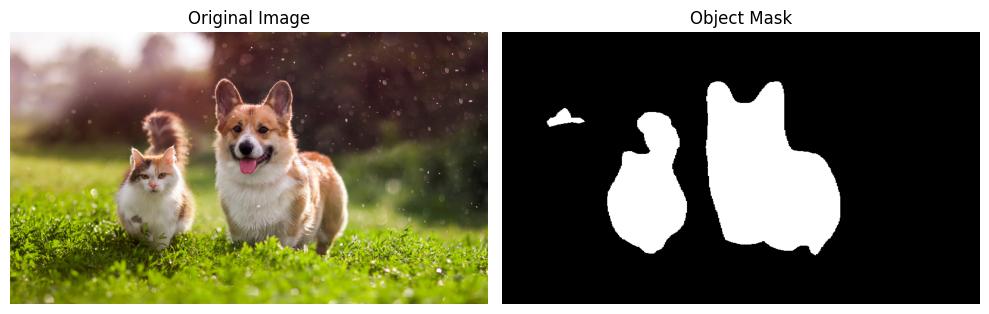

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 0, Loss: 5928332084379648.0000
Step 50, Loss: 781128453586944.0000
Step 100, Loss: 301171763838976.0000
Step 150, Loss: 174060327665664.0000
Step 200, Loss: 120291942465536.0000
Step 250, Loss: 91993048875008.0000


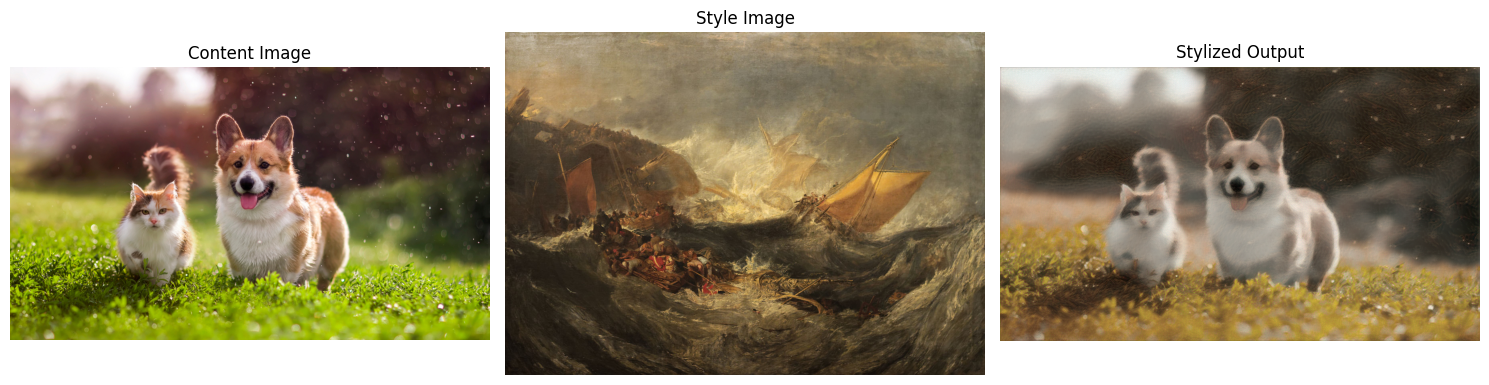

In [ ]:
run_style_transfer("/content/CatAndDogClear.jpg", "/content/1200px-Shipwreck_of_the_Minotaur_William_Turner.jpg")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


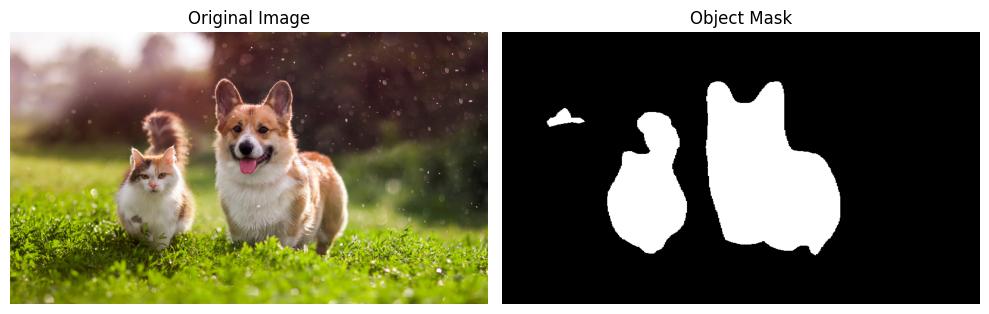

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 0, Loss: 15492333583728640.0000
Step 50, Loss: 4553721358843904.0000
Step 100, Loss: 1523479660724224.0000
Step 150, Loss: 505033359622144.0000
Step 200, Loss: 316514729197568.0000
Step 250, Loss: 237404954820608.0000


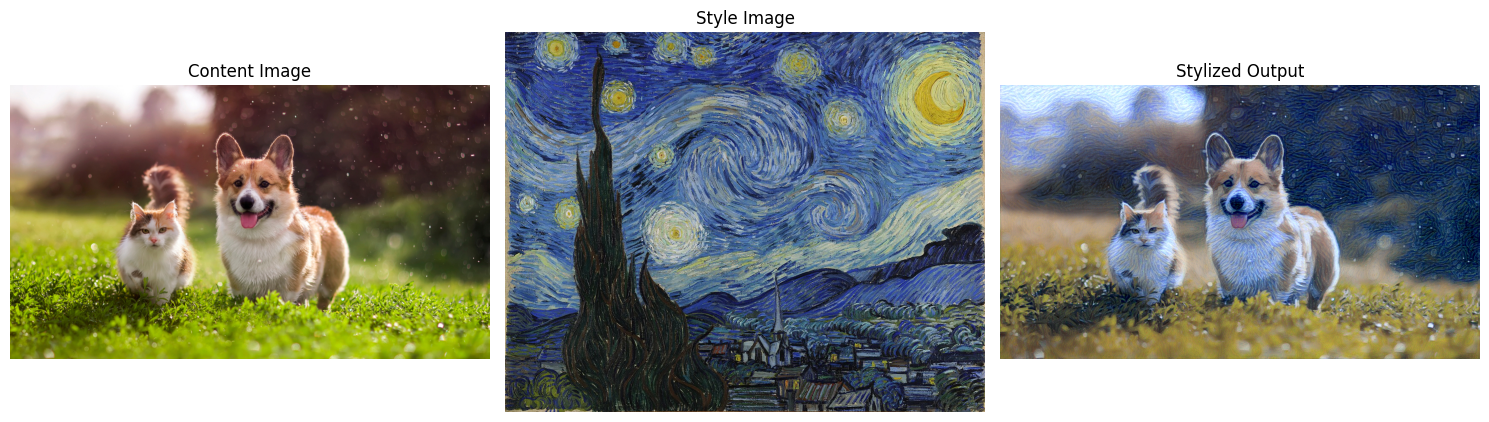

In [ ]:
run_style_transfer("/content/CatAndDogClear.jpg", "/content/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


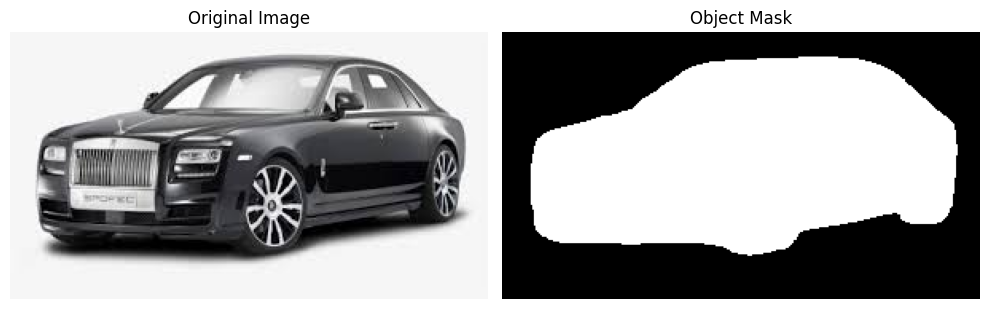

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 0, Loss: 9586601080389632.0000
Step 50, Loss: 1820380952002560.0000
Step 100, Loss: 917784447942656.0000
Step 150, Loss: 672380955394048.0000
Step 200, Loss: 550158030864384.0000
Step 250, Loss: 471894667034624.0000


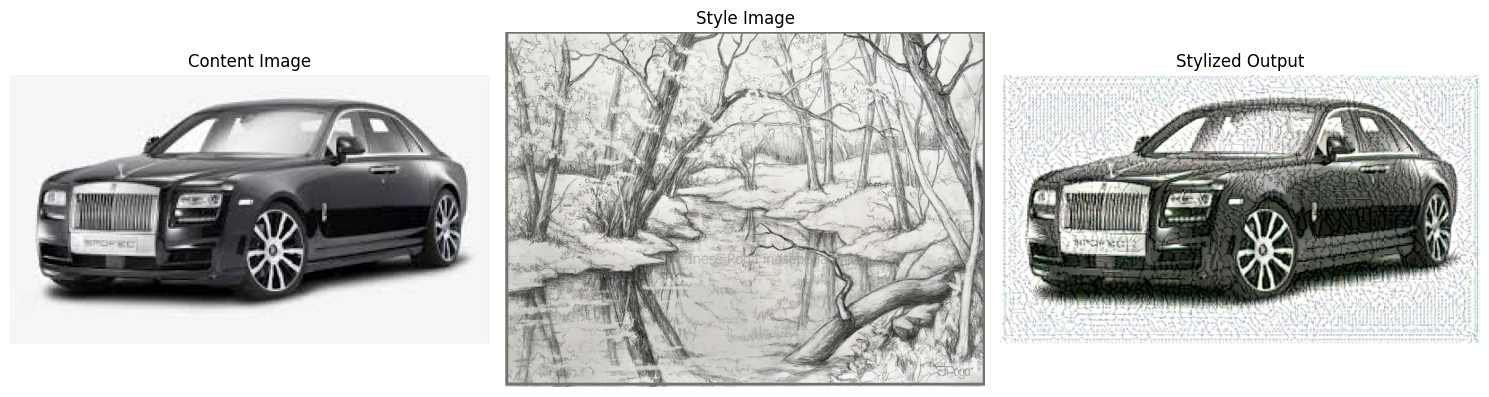

In [ ]:
run_style_transfer("/content/rrcar.jpeg", "/content/pencilSketch.webp")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


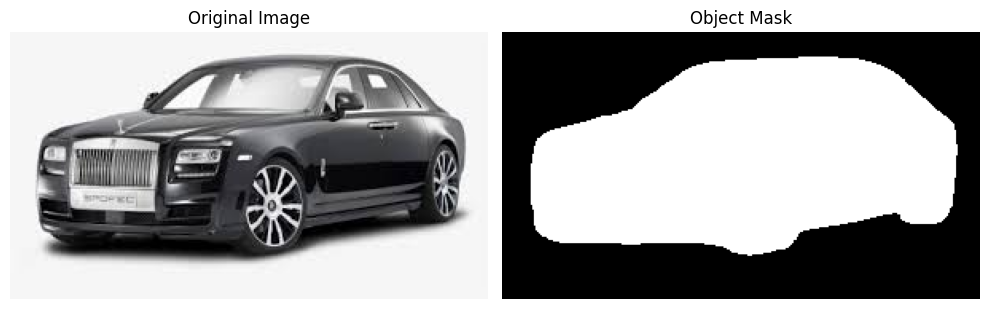

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 0, Loss: 818589762322432.0000
Step 50, Loss: 194090343858176.0000
Step 100, Loss: 139142864306176.0000
Step 150, Loss: 114365499965440.0000
Step 200, Loss: 99415691886592.0000
Step 250, Loss: 89354034741248.0000


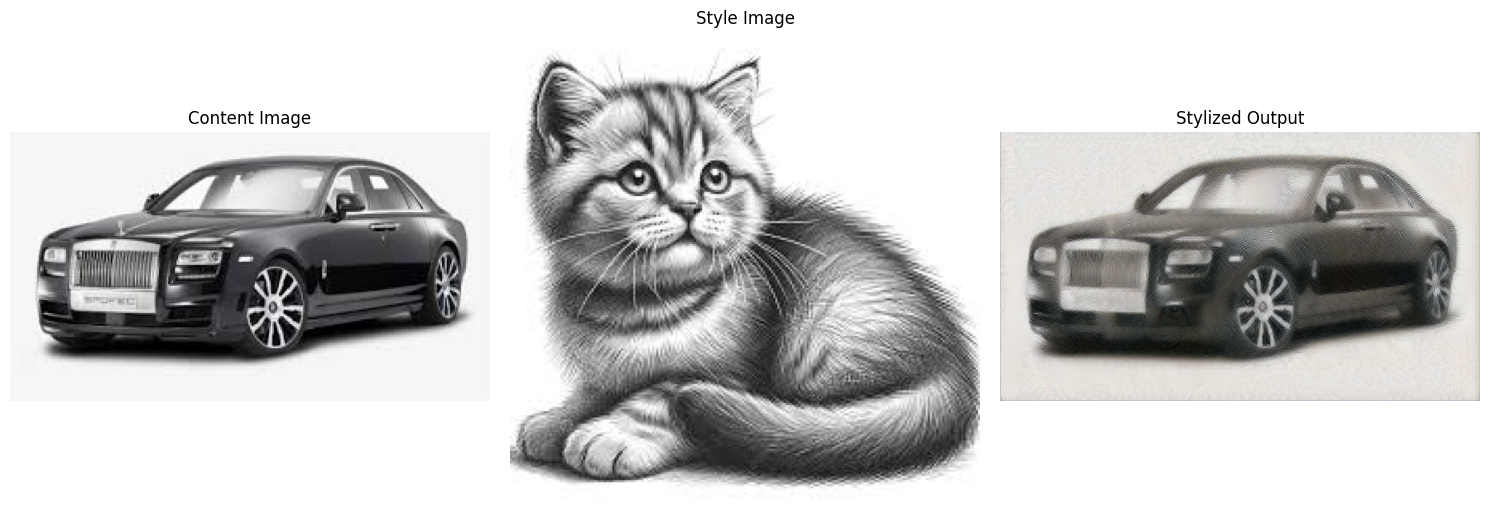

In [ ]:
run_style_transfer("/content/rrcar.jpeg", "/content/pencilSketch2.jpeg")

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 165MB/s]


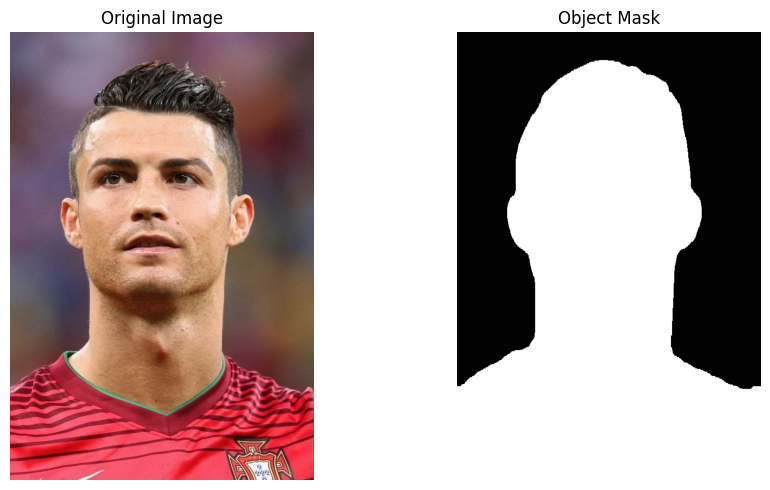

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 91.1MB/s]


Step 0, Loss: 10450433893990400.0000
Step 50, Loss: 2524951143776256.0000
Step 100, Loss: 1469849209405440.0000
Step 150, Loss: 1089154045706240.0000
Step 200, Loss: 906882411659264.0000
Step 250, Loss: 805227582193664.0000


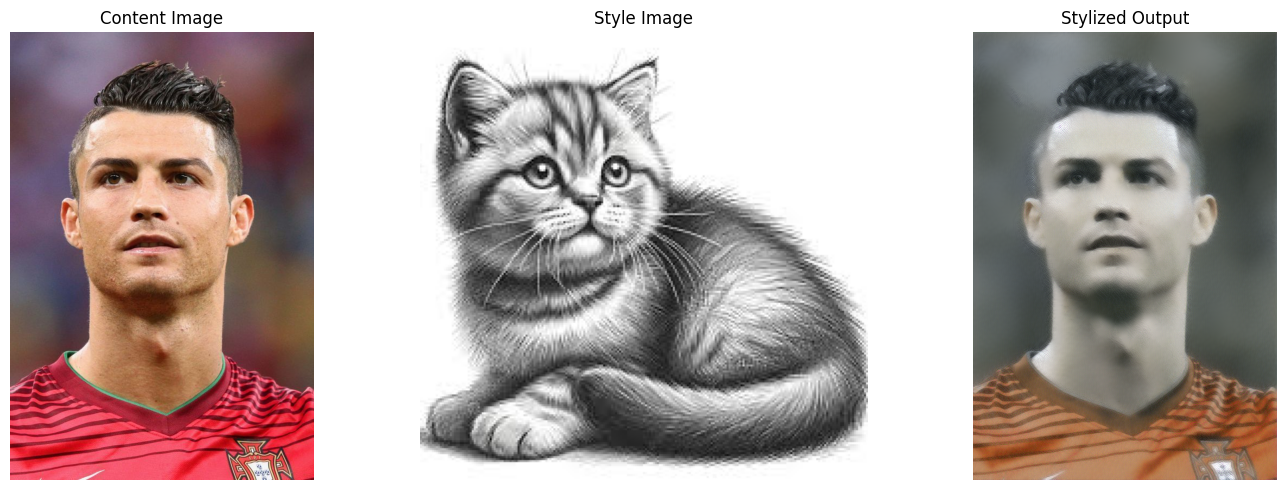

In [ ]:
run_style_transfer("/content/ronaldo.jpg", "/content/pencilSketch2.jpeg")